In [1]:
# Assignment 4: SIR model, MCMC for R0
# Jan Nagler
# based on https://docs.pymc.io/pymc-examples/examples/ode_models/ODE_API_introduction.htm
import numpy as np
import matplotlib.pyplot as plt
%precision 4 
%matplotlib inline
import pymc3 as pm #install if necessary
from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint
import warnings
warnings.filterwarnings("ignore") 
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
np.random.seed(42)

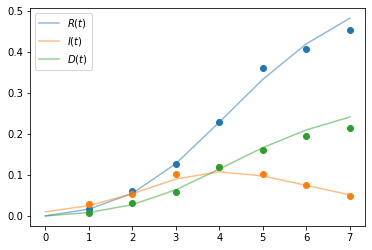

In [9]:
# Define initial conditions of SIR model
# S0 = N - I0 - R0
# N = 1
r0 = 0.00 #fraction of recovered at time t0=0
i0 = 0.01 #fractions infected at time t0=0 (1%)
d0 = 0.00 #fraction of dead at time t0=0
f = 1.5 #3.0 # time factor - defines total time window range
timestep_data = 1 # dt for data (e.g., weekly)

############### 这里就是核心model，就是之前见过的SIR 积分model，这个model不再是Gaussian分布，因为他depend on time，则有不同的shape；  ODE SIR system, only parameter p[0]=R0=β, R0 = β / Ɣ for scaled time t/gamma (optimized, and 1=gamma)
def SIR(y, t, p):
    ############### ds = -p[0]*y[0]*y[1] = noise*I*R, we do not need susceptibles as S=1-I-R is dependent on I and R, 就形成了用I和R描述的一个S式子，用p[0]来模拟需要的两个参数即 β对应I，Ɣ对应R； 
    ############### y's compartment 0 = y[0] R = recovered；  y's compartment 1 = y[1] = I = infected
    ############### dr = y[1] # 因为gamma=1 也就是全部感染的人100%恢复，则本轮t的y[1]=下一个t+1的y[0]
    di = p[0]*(1-y[0]-y[1]-p[1]*y[1])*y[1] -y[1] -p[1]*y[1]
    ############### SIR in one line: p[0]为noise，(1-y[0]-y[1])=1-R-I= S, 因为gamma=100%则本t内的y[1]就是下一轮t+1的R, 则有这样的关系 dI = p[0]*S*R - R  
    ############### 这里的p[0]相当于是用一个model来估计????
    return [y[1], di, p[1]*y[1]] 
    ############### return r(ecover) and i(nfect)，因为gamma=100%=1则第一项y[1]I的人全部Recover了,基本轮t内感染的人I全部变成下一轮Tt+1的恢复的人R

times = np.arange(0,5*f,timestep_data)

#ground truth (fixed gamma=1, then R0=beta, time scale to t/gamma)
beta = 2.5 ############### 就是infection % = β
mu =0.5

# Create SIR curves
y = odeint(SIR, t=times, y0=[r0, i0, d0], args=([beta, mu],), rtol=1e-8) # r0 recovered, i0 infected  at t0

############### 这个就和之前的Y_obs一个意思，因Observational model 是专门 for muliplicative noise，因为下一个传染阶段取决于上一个传染阶段的人数，前后是proportional的，因此用lognormal Dist更合理
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.1, 0.1, 0.1]) # noise is multiplicative (makes sense here)
#yobs = np.random.normal(loc=(y[1::]), scale=[0.030, 0.060]) # noise is additive (wrong here)############## 这个likelihood model对SIR积分model不可用

# Plot the deterministic curves, and those with multiplicative noise
plt.plot(times[1::],yobs, marker='o', linestyle='none')
plt.plot(times, y[:,0], color='C0', alpha=0.5, label=f'$R(t)$')
plt.plot(times, y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
plt.plot(times, y[:,2], color ='C2', alpha=0.5, label=f'$D(t)$')
plt.legend()
plt.show()


Only 400 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [mu, R0, sigma]


Sampling 2 chains for 1_000 tune and 400 draw iterations (2_000 + 800 draws total) took 400 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma[0],2.38,0.74,1.33,3.72,0.03,0.02,762.0,473.0,1.01
sigma[1],2.99,0.90,1.65,4.61,0.04,0.02,771.0,696.0,1.01
sigma[2],3.03,0.97,1.73,4.51,0.05,0.04,749.0,369.0,1.00
R0,2.03,0.84,0.46,3.64,0.03,0.02,751.0,433.0,1.00
mu,0.51,0.10,0.34,0.72,0.00,0.00,709.0,544.0,1.00


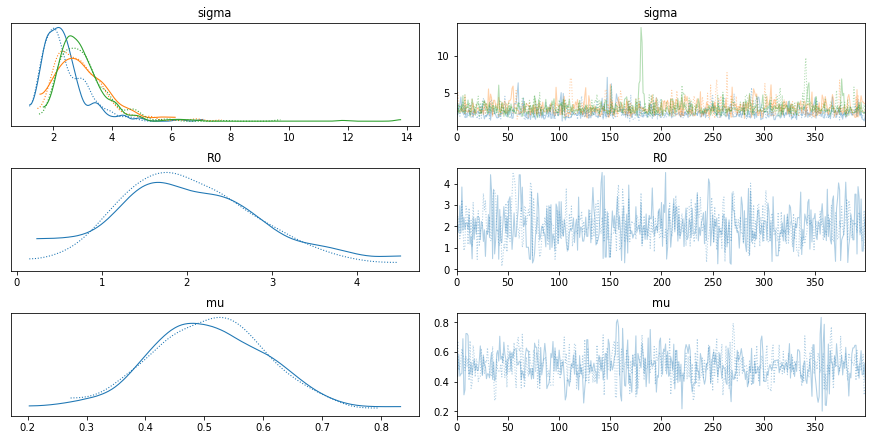

In [10]:
# ODE system container
sir_model = DifferentialEquation(
    func = SIR,
    times = np.arange(timestep_data, 5*f, timestep_data), #start at t=t_1 (and not t0=0, where log(R=0)=undef)
    n_states = 3, #R(ecovered), I(nfected) and D(ead) are states
    n_theta = 2, # beta=R0 and mu two parameter
    t0 = 0 # start from zero
)

# Define and perform MCMC
with pm.Model() as basic_model:

    # Distribution of variances, sigma[0] and sigma[1], some good choice, pos. chauchy  
    sigma = pm.HalfCauchy( 'sigma', 1, shape=3 )

    # Prior: R0 is bounded from below (lower=1), (R0, mu=2, sigma=3)
    R0 = pm.Bound(pm.Normal, lower=0.1, upper=5)('R0', 2.5, 1 ) # guess of how R0 distribution looks like = Guassian, mean>1
    
    # Prior: mu is bounded from below (lower=0), (mu, mu=1, sigma=2)
    mu = pm.Bound(pm.Normal, lower=0.01, upper=1)('mu', 0.5, 0.1) # guess of how R0 distribution looks like = Guassian, mean>1
    
    # Our deterministic curves
    sir_curves = sir_model( y0=[r0, i0, d0], theta=[R0, mu] ) # assume gamma = 1, then beta=R0

    # Likelihood function choice: our sampling distribution for multiplicative noise around the I and R curves
    Y = pm.Lognormal('Y', mu=sir_curves, sd=sigma, observed=yobs) # variances via sigmas, data=yobs;"mu=pm.math.log(sir_curves)" Not working
    
    start = pm.find_MAP()
    
    step = pm.NUTS()
    
    trace = pm.sample(400, step=step, cores=1, random_seed=44) #set here number of cores, to adapt for hardware

# Plot results (takes a while, be patient)
pm.traceplot(trace)
pm.summary(trace).round(2)

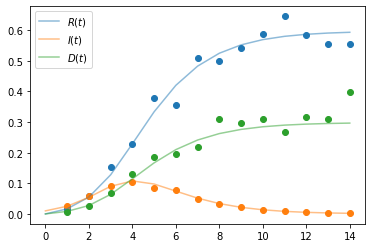

In [14]:
# Define initial conditions of SIR model
# S0 = N - I0 - R0
# N = 1
r0 = 0.00 #fraction of recovered at time t0=0
i0 = 0.01 #fractions infected at time t0=0 (1%)
d0 = 0.00 #fraction of dead at time t0=0
f = 3 #3.0 # time factor - defines total time window range
timestep_data = 1 # dt for data (e.g., weekly)

############### 这里就是核心model，就是之前见过的SIR 积分model，这个model不再是Gaussian分布，因为他depend on time，则有不同的shape；  ODE SIR system, only parameter p[0]=R0=β, R0 = β / Ɣ for scaled time t/gamma (optimized, and 1=gamma)
def SIR(y, t, p):
    ############### ds = -p[0]*y[0]*y[1] = noise*I*R, we do not need susceptibles as S=1-I-R is dependent on I and R, 就形成了用I和R描述的一个S式子，用p[0]来模拟需要的两个参数即 β对应I，Ɣ对应R； 
    ############### y's compartment 0 = y[0] R = recovered；  y's compartment 1 = y[1] = I = infected
    ############### dr = y[1] # 因为gamma=1 也就是全部感染的人100%恢复，则本轮t的y[1]=下一个t+1的y[0]
    di = p[0]*(1-y[0]-y[1]-p[1]*y[1])*y[1] -y[1] -p[1]*y[1]
    ############### SIR in one line: p[0]为noise，(1-y[0]-y[1])=1-R-I= S, 因为gamma=100%则本t内的y[1]就是下一轮t+1的R, 则有这样的关系 dI = p[0]*S*R - R  
    ############### 这里的p[0]相当于是用一个model来估计__________________________________________????
    return [y[1], di, p[1]*y[1]] 
    ############### return r(ecover) and i(nfect)，因为gamma=100%=1则第一项y[1]I的人全部Recover了,基本轮t内感染的人I全部变成下一轮Tt+1的恢复的人R

times = np.arange(0,5*f,timestep_data)

#ground truth (fixed gamma=1, then R0=beta, time scale to t/gamma)
beta = 2.5 ############### 就是infection % = β
mu =0.5

# Create SIR curves
y = odeint(SIR, t=times, y0=[r0, i0, d0], args=([beta, mu],), rtol=1e-8) # r0 recovered, i0 infected  at t0

############### 这个就和之前的Y_obs一个意思，因Observational model 是专门 for muliplicative noise，因为下一个传染阶段取决于上一个传染阶段的人数，前后是proportional的，因此用lognormal Dist更合理
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.1, 0.1, 0.1]) # noise is multiplicative (makes sense here)
#yobs = np.random.normal(loc=(y[1::]), scale=[0.030, 0.060]) # noise is additive (wrong here)############## 这个likelihood model对SIR积分model不可用

# Plot the deterministic curves, and those with multiplicative noise
plt.plot(times[1::],yobs, marker='o', linestyle='none')
plt.plot(times, y[:,0], color='C0', alpha=0.5, label=f'$R(t)$')
plt.plot(times, y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
plt.plot(times, y[:,2], color ='C2', alpha=0.5, label=f'$D(t)$')
plt.legend()
plt.show()


Only 400 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [mu, R0, sigma]


Sampling 2 chains for 1_000 tune and 400 draw iterations (2_000 + 800 draws total) took 557 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma[0],1.69,0.36,1.09,2.35,0.02,0.01,575.0,425.0,1.0
sigma[1],4.11,0.77,2.80,5.54,0.03,0.02,643.0,484.0,1.0
sigma[2],2.26,0.44,1.48,3.03,0.02,0.02,440.0,380.0,1.0
R0,1.00,0.56,0.11,1.99,0.02,0.02,461.0,366.0,1.0
mu,0.34,0.22,0.02,0.72,0.01,0.01,354.0,402.0,1.0


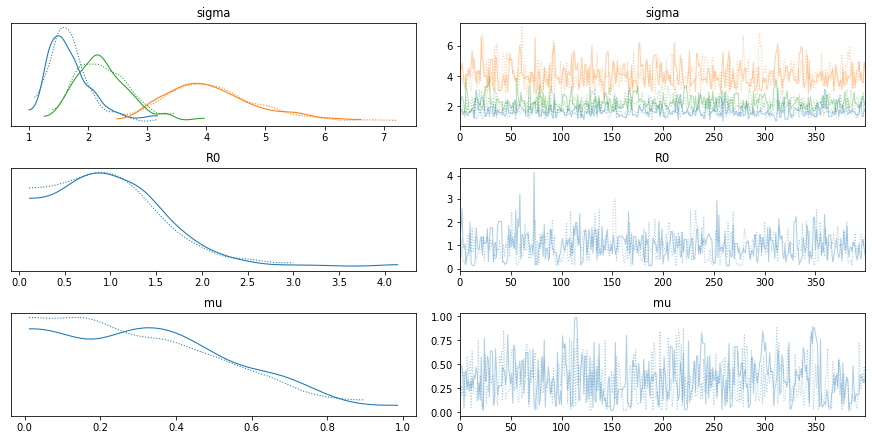

In [15]:
# ODE system container
sir_model = DifferentialEquation(
    func = SIR,
    times = np.arange(timestep_data, 5*f, timestep_data), #start at t=t_1 (and not t0=0, where log(R=0)=undef)
    n_states = 3, #R(ecovered), I(nfected) and D(ead) are states
    n_theta = 2, # beta=R0 and mu two parameter
    t0 = 0 # start from zero
)

# Define and perform MCMC
with pm.Model() as basic_model:

    # Distribution of variances, sigma[0] and sigma[1], some good choice, pos. chauchy  
    sigma = pm.HalfCauchy( 'sigma', 1, shape=3 )

    # Prior: R0 is bounded from below (lower=1), (R0, mu=2, sigma=3)
    R0 = pm.Bound(pm.Normal, lower=0.1)('R0', 1.5, 2 ) # guess of how R0 distribution looks like = Guassian, mean>1
    
    # Prior: mu is bounded from below (lower=0), (mu, mu=1, sigma=2)
    mu = pm.Bound(pm.Normal, lower=0.01, upper=1)('mu', 0.2, 0.3) # guess of how R0 distribution looks like = Guassian, mean>1
    
    # Our deterministic curves
    sir_curves = sir_model( y0=[r0, i0, d0], theta=[R0, mu] ) # assume gamma = 1, then beta=R0

    # Likelihood function choice: our sampling distribution for multiplicative noise around the I and R curves
    Y = pm.Lognormal('Y', mu=sir_curves, sd=sigma, observed=yobs) # variances via sigmas, data=yobs;"mu=pm.math.log(sir_curves)" Not working
    
    start = pm.find_MAP()
    
    step = pm.NUTS()
    
    trace = pm.sample(400, step=step, cores=1, random_seed=44) #set here number of cores, to adapt for hardware

# Plot results (takes a while, be patient)
pm.traceplot(trace)
pm.summary(trace).round(2)